In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [ ]:
paths = []
labels = []
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset/audio/Tess'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/Dataset/audio/Tess/TESS...,fear
1,/content/drive/MyDrive/Dataset/audio/Tess/TESS...,fear
2,/content/drive/MyDrive/Dataset/audio/Tess/TESS...,fear
3,/content/drive/MyDrive/Dataset/audio/Tess/TESS...,fear
4,/content/drive/MyDrive/Dataset/audio/Tess/TESS...,fear


In [ ]:
df['label'].value_counts()

,count
label,
fear,800
ps,800
sad,800
angry,800
disgust,800
happy,800
neutral,800


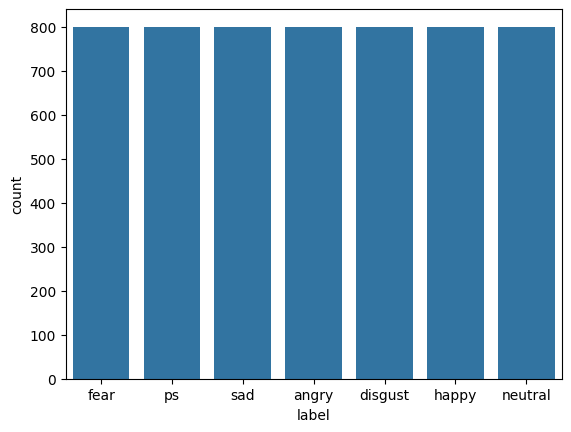

In [ ]:
sns.countplot(x = df['label'])
plt.show()

In [ ]:
# Assuming your DataFrame df is already created with paths and labels
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

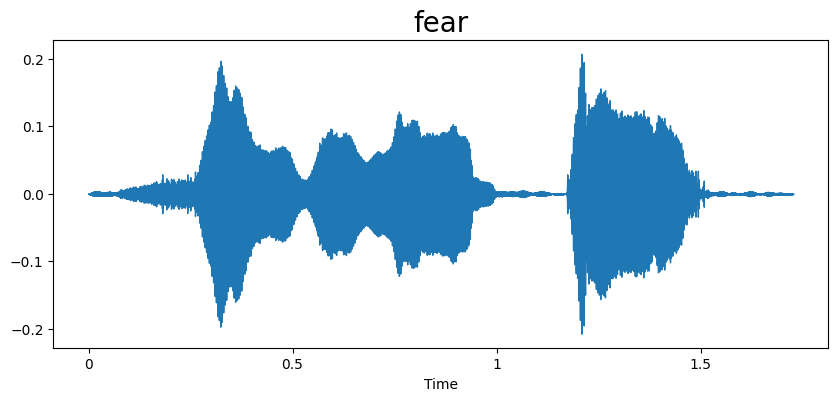

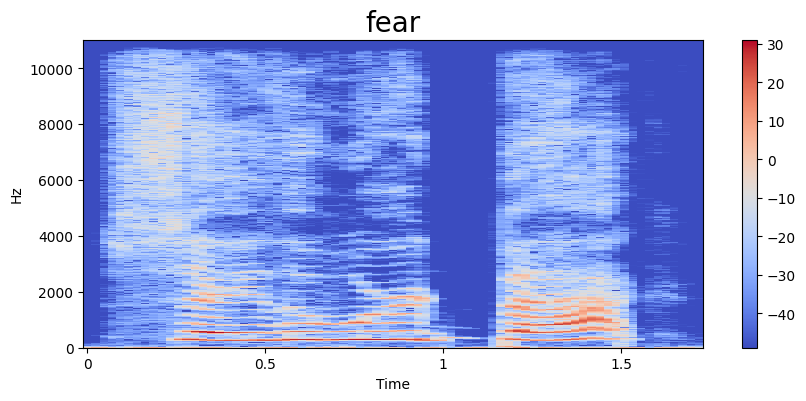

In [ ]:
emotion = 'fear'
path = df['speech'][df['label'] == emotion][0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

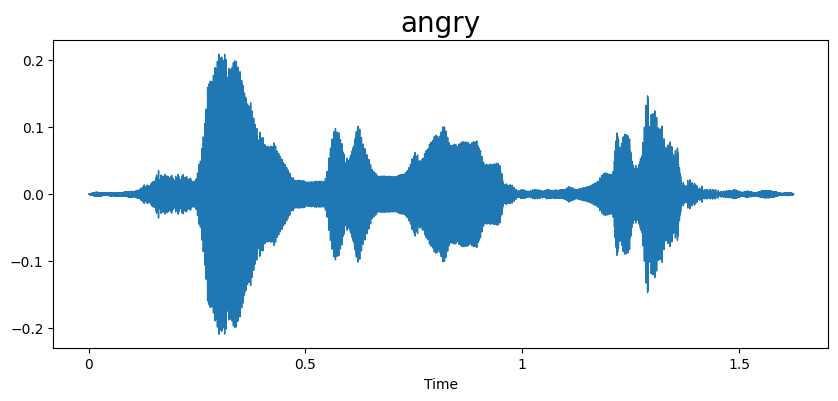

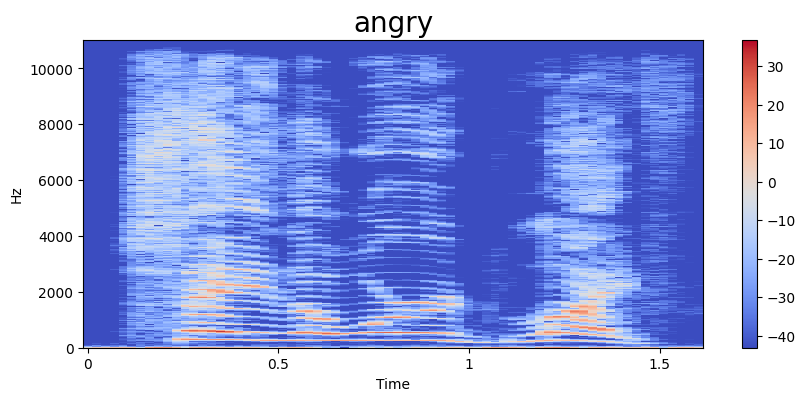

In [ ]:
emotion = 'angry'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

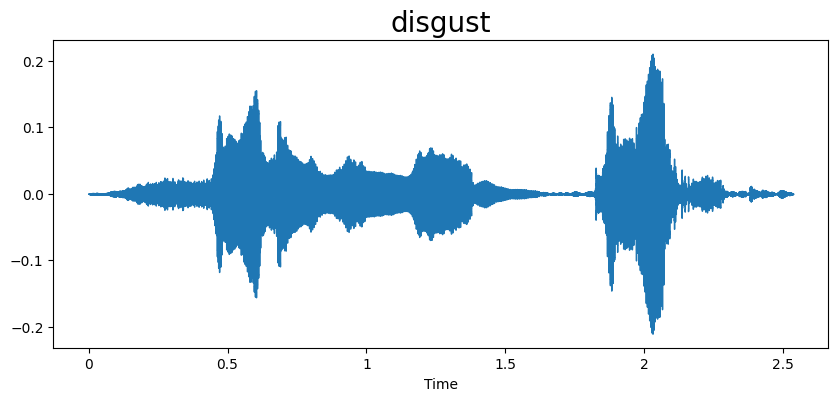

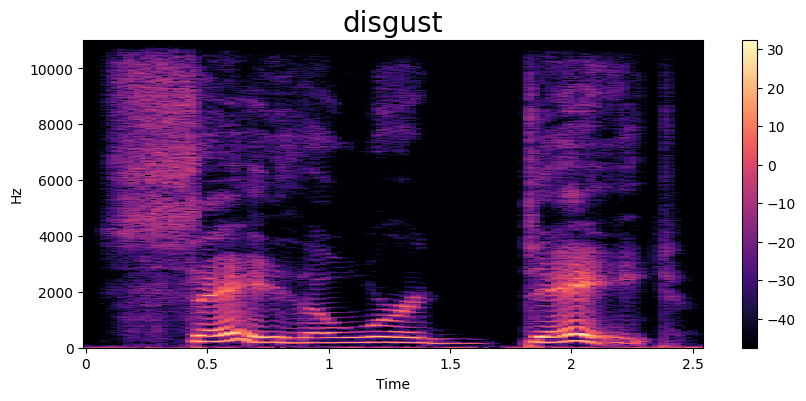

In [ ]:
emotion = 'disgust'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

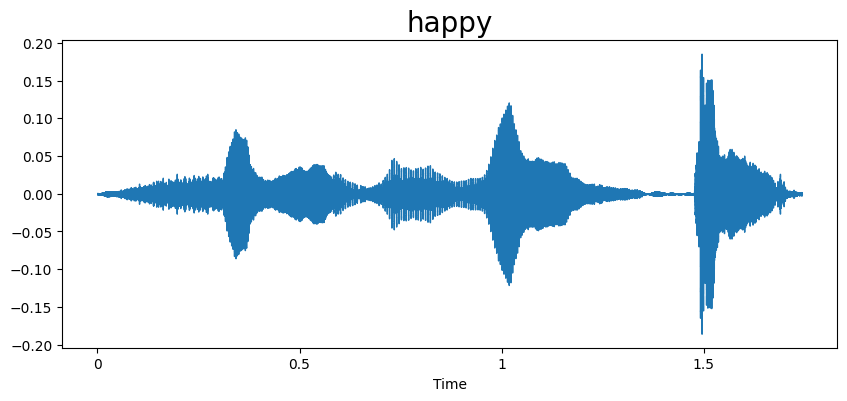

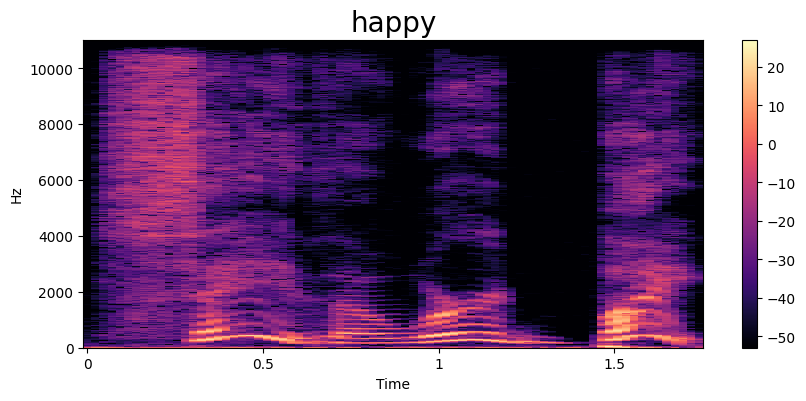

In [ ]:
emotion = 'happy'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

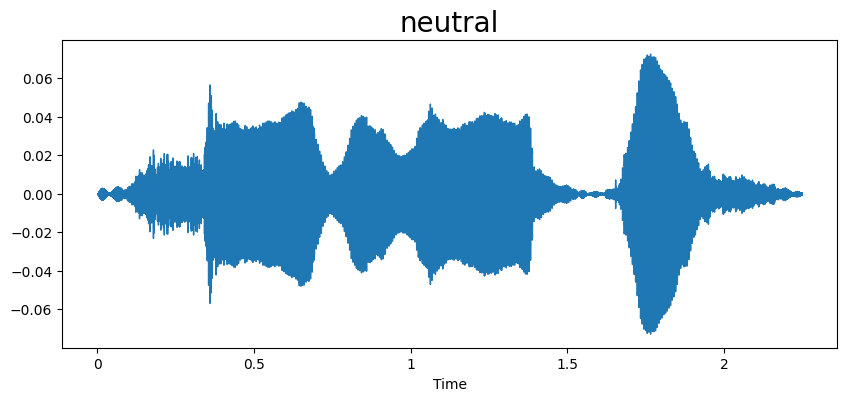

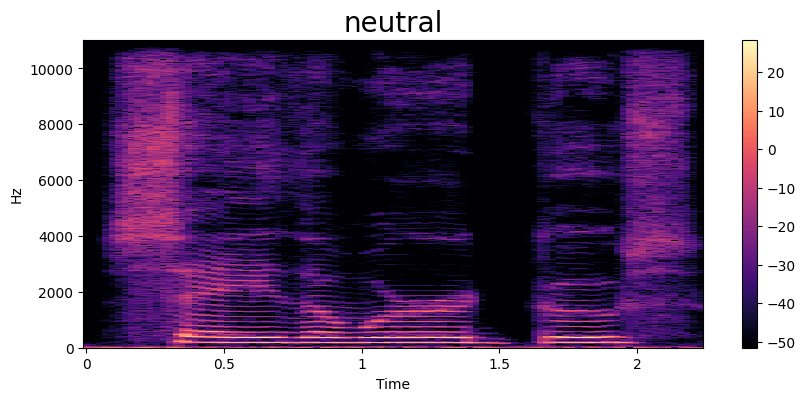

In [ ]:
emotion = 'neutral'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

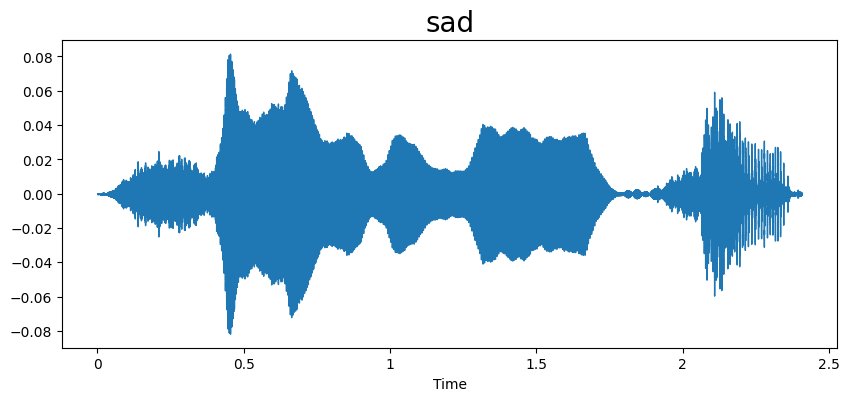

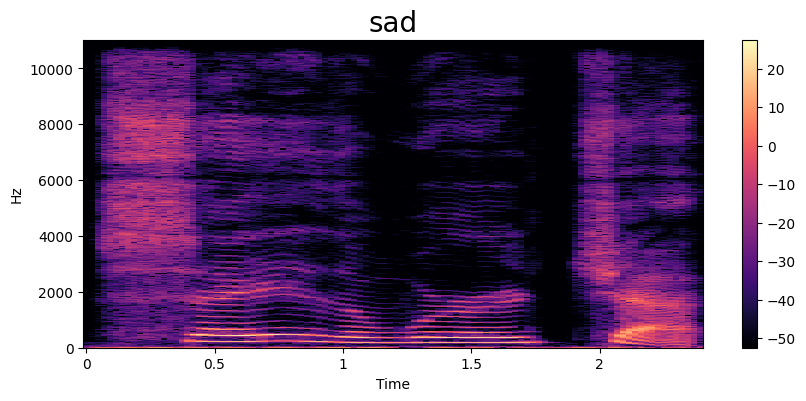

In [ ]:
emotion = 'sad'
path = np.array(df['speech'][df['label'] == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

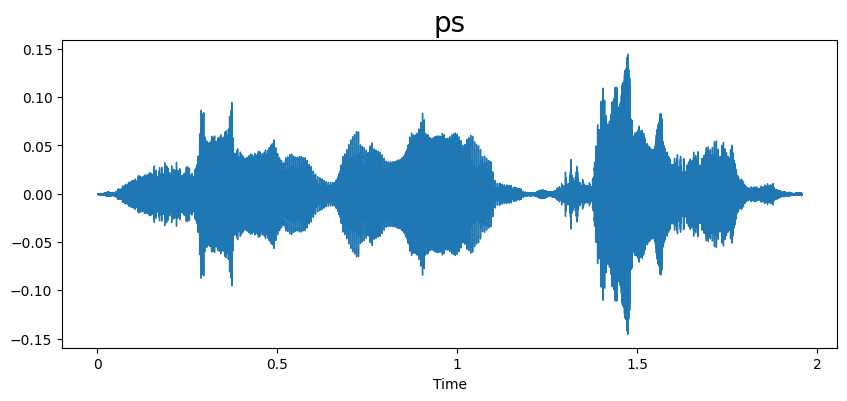

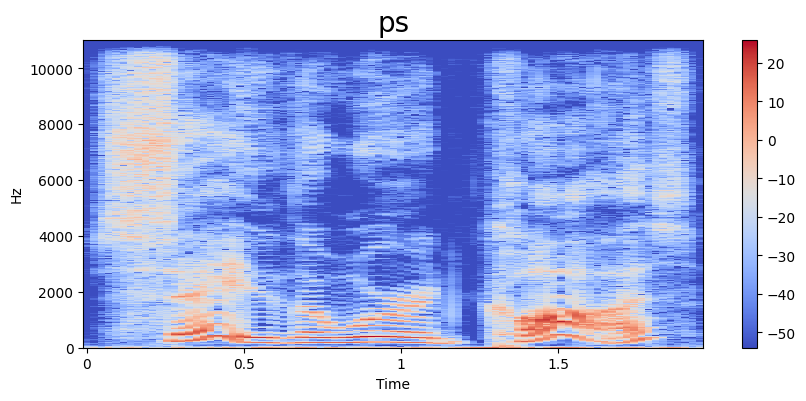

In [ ]:
emotion = 'ps'
path = np.array(df['speech'][df['label'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def extract_mfcc(filename, max_pad_len=100):
    y, sr = librosa.load(filename, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

In [ ]:
# Extract MFCCs for each audio file
x_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
x = np.array([x for x in x_mfcc])
x = np.expand_dims(x, -1)  # Expanding dimensions for LSTM input

In [ ]:
# One-Hot Encode labels
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']]).toarray()

In [ ]:
print(y[:5])  # Prints the first 5 elements of the array


[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x.reshape(-1, 40)).reshape(x.shape)

In [ ]:
print(np.isnan(x).any(), np.isinf(x).any())


False False


In [ ]:
# Reshape input data
x = x.squeeze(-1)  # Remove the last dimension

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
# Define the model with the correct input shape
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=False, input_shape=(40, 100))),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('Audio_sentimentAnalysis_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [ ]:
# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.1613 - loss: 2.1541 - val_accuracy: 0.2712 - val_loss: 1.8328 - learning_rate: 1.0000e-04
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.2554 - loss: 1.8606 - val_accuracy: 0.4286 - val_loss: 1.6630 - learning_rate: 1.0000e-04
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.3331 - loss: 1.7074 - val_accuracy: 0.5636 - val_loss: 1.4940 - learning_rate: 1.0000e-04
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.4378 - loss: 1.5302 - val_accuracy: 0.6629 - val_loss: 1.3278 - learning_rate: 1.0000e-04
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.5045 - loss: 1.3840 - val_accuracy: 0.7288 - val_loss: 1.1453 - learning_rate: 1.0000e-04
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.5688 - loss: 1.2501 - val_accuracy: 0.7824 - val_loss: 1.0119 - learning_rate: 1.0000e-04
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step 

In [ ]:
# Function to plot training and validation metrics
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

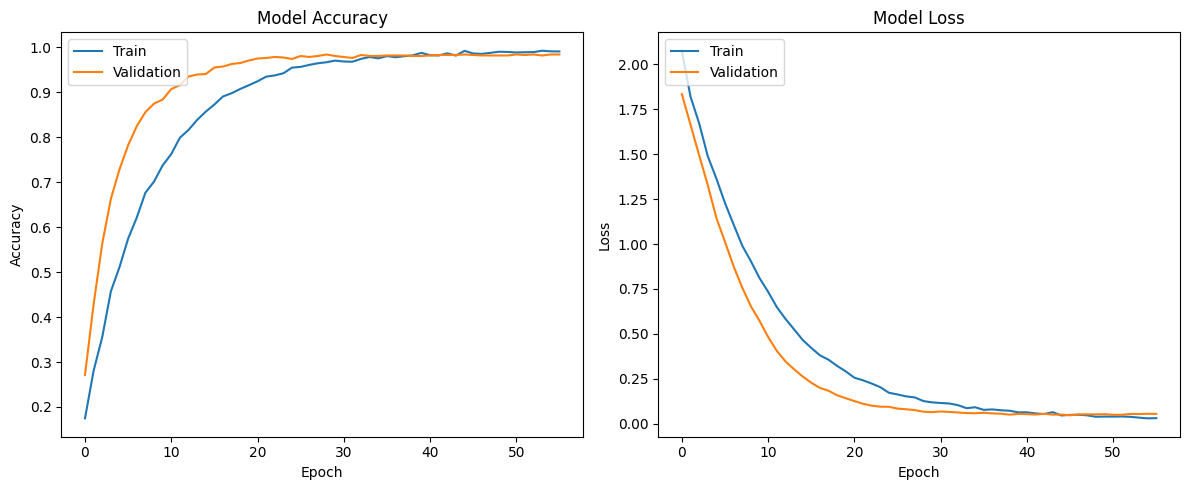

In [ ]:
plot_metrics(history)

In [ ]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/Audio_SentimentAnalysis_model.h5')

In [ ]:

# Load the model
loaded_model = load_model('/content/drive/MyDrive/Audio_SentimentAnalysis_model.h5')


In [ ]:
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.9877 - loss: 0.0368
Test Loss: 0.03881167620420456
Test Accuracy: 0.9866071343421936


In [ ]:
y_pred = loaded_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step


In [ ]:
y_pred_classes = y_pred.argmax(axis=-1)

In [ ]:
import numpy as np

# Convert y_test from one-hot encoding to class labels if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=-1)
else:
    y_test_labels = y_test  # already in label format

# Generate a classification report
print(classification_report(y_test_labels, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       160
           1       0.98      0.99      0.98       160
           2       0.96      0.99      0.98       160
           3       0.98      0.97      0.98       160
           4       1.00      1.00      1.00       160
           5       0.99      0.98      0.99       160
           6       0.99      1.00      1.00       160

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120



[[156   0   4   0   0   0   0]
 [  0 158   0   0   0   1   1]
 [  0   0 158   2   0   0   0]
 [  0   2   2 156   0   0   0]
 [  0   0   0   0 160   0   0]
 [  0   2   0   1   0 157   0]
 [  0   0   0   0   0   0 160]]


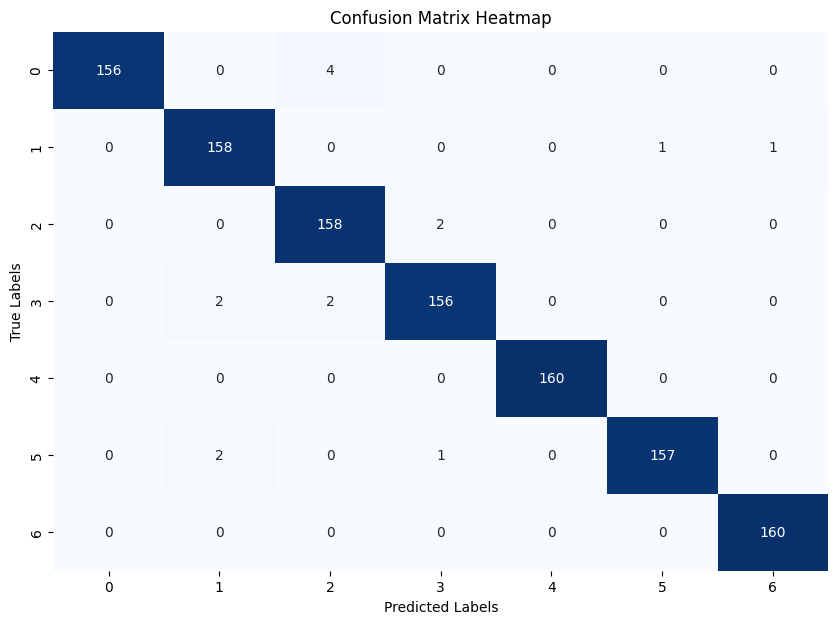

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_labels, y_pred_classes)
print(conf_matrix)
# Plotting the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()